# Import Packages

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary
from sklearn.preprocessing import StandardScaler
import gc


import os
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')


pd.set_option('display.max_columns', None)
rootdir = r'C:\\Users\\bened\\Documents\\UNIVERSITY\\SchoenStats\\PyTorch Working Directory\\Undergrad Stats Project\\Crime Models\\Crime Data Devon and Cornwall'

# Load DATA

In [7]:
# collect dataframes from files
dat_2018_list = []
dat_2019_list = []
dat_2020_list = []
dat_2021_list = []
for root, dirs, files in os.walk(rootdir):
    for file in tqdm(files):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(root, file))
            if file.startswith('2018'):
                dat_2018_list.append(df)
            elif file.startswith('2019'):
                dat_2019_list.append(df)
            elif file.startswith('2020'):
                dat_2020_list.append(df)
            else:
                dat_2021_list.append(df)

100%|██████████| 36/36 [00:03<00:00,  9.36it/s]


In [8]:
def clean_dat_fn(dat_list):
    df = pd.concat(dat_list)
    df['Month'] = [int(i.split('-')[1]) for i in df['Month']]
    df['Crime type'] = df['Crime type'].astype('category')
    df_out = df[['Month', 'Longitude', 'Latitude', 'Crime type']]
    return(df_out)

In [9]:
mllc18 = clean_dat_fn(dat_2018_list)
mllc19 = clean_dat_fn(dat_2019_list)
mllc20 = clean_dat_fn(dat_2020_list)
mllc21 = clean_dat_fn(dat_2021_list)

In [29]:
data = mllc18[['Longitude', 'Latitude']].dropna()

# random sample from dataset
X = data.sample(10000).reset_index(drop=True)
X = X[(X.Longitude.notna()) & (X.Longitude < -2.8) & (X.Longitude > -5.8)]
X = X[(X.Latitude.notna()) & (X.Latitude < 51.5) & (X.Latitude > 49.5)]
X_data = torch.round(torch.tensor(X.values)*111)

X = data.sample(2000).reset_index(drop=True)
X = X[(X.Longitude.notna()) & (X.Longitude < -2.8) & (X.Longitude > -5.8)]
X = X[(X.Latitude.notna()) & (X.Latitude < 51.5) & (X.Latitude > 49.5)]
X_test = torch.round(torch.tensor(X.values)*111)

In [30]:
#n_samples = 2000
#noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X = np.array(X_data)
y = np.array(X_test)
# normalize
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

In [31]:
X_data = X
X_test = y
X_data = torch.tensor(X_data)
X_test = torch.tensor(X_test)

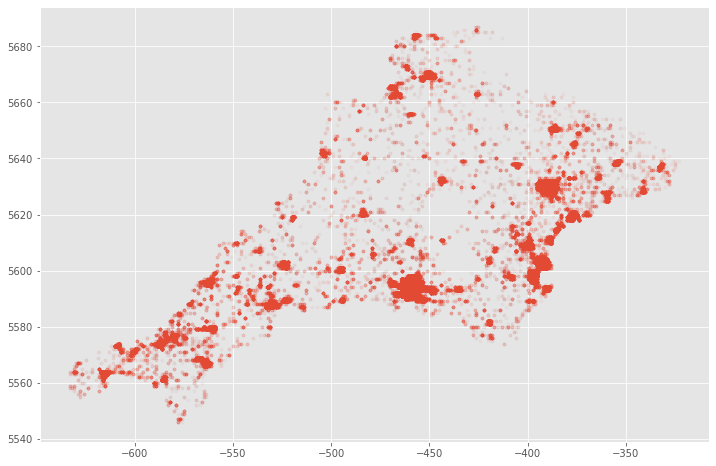

In [32]:
# plot generated dataset
k = mllc18
k = k[(k.Longitude.notna()) & (k.Longitude < -2.8) & (k.Longitude > -5.8)]
k =  k[(k.Latitude.notna()) & (k.Latitude < 51.5) & (k.Latitude > 49.5)]
long, lat = k['Longitude'], k['Latitude']

plt.figure(figsize=(12, 8))
plt.scatter(round(long*111), round(lat*111), s=10, alpha=0.05)

In [33]:
# create features data and target data
X_train = X_data.view(-1,2)
X_test = X_test.view(-1,2)

Text(0.5, 1.0, 'Training Distribution')

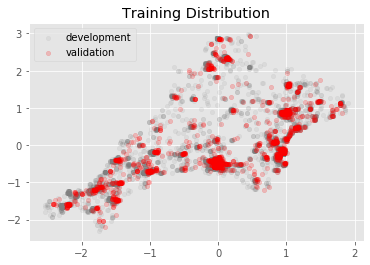

In [34]:
# plot generated dataset
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.1, s=20, label='development', color='grey')
plt.scatter(X_test[:,0], X_test[:,1], alpha=0.2, s=20, label='validation', color='red')
plt.legend(loc='upper left')
plt.title("Training Distribution")

In [35]:
# create features data and target data
X_train = X_train.view(-1,2)
X_test = X_test.view(-1,2)

# Define MODEL and Loss Function

In [36]:
n_input = 1
n_output = 1
n_gaus = 10
n_hidden = 30
# define MODEL
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        
        self.z_h = nn.Sequential(nn.Linear(n_input, n_hidden),
                                 nn.Tanh(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.Tanh(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.Tanh())
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        
        #self.z_pi = nn.Linear(n_hidden, n_gaussians)
        #self.z_mu = nn.Linear(n_hidden, n_gaussians)
        #self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=n_hidden, n_gaussians=n_gaus)

optimizer = torch.optim.Adam(model.parameters())

In [37]:
# defining LOSS function
# modification to the error loss function (because it is an MDN)
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

# Training Step

In [38]:
# TRAINING the model
num_epoch = 500
batch_size = 64

model=model.double()
loss_list = []

for epoch in tqdm(range(num_epoch)): 
    permu = torch.randperm(X_train.shape[0])
    
    for i in range(0, X_train.shape[0], batch_size):
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_train[indices,0], X_train[indices,1]
        pi, mu, sigma = model.forward(batch_x.unsqueeze(1))
        optimizer.zero_grad()
        l = mdn_loss_fn(batch_y.unsqueeze(1), mu, sigma, pi)
        l.backward()
        optimizer.step()

    if epoch % 1 == 0:
        loss_list.append(l.detach())

100%|██████████| 500/500 [07:21<00:00,  1.13it/s]


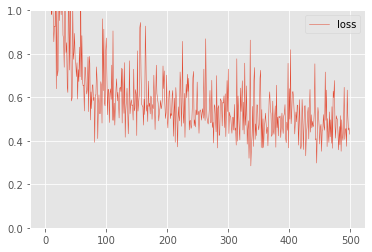

In [39]:
# Epochs vs (log)Loss
#plt.plot(range(num_epoch), np.array(loss_list), label='log.loss', linewidth=0.5)
#plt.ylim((-2.5, 0.5))
#plt.legend()

# Epochs vs Loss
plt.plot(range(num_epoch), np.exp(np.array(loss_list)), label='loss', linewidth=0.5)
plt.ylim((0, 1))
plt.legend()

# Sampling Data from Trained Model

In [43]:
pi, mu, sigma = model(X_test[:,0].unsqueeze(1))

In [44]:
sigma

tensor([[0.0234, 1.3345, 0.1416,  ..., 0.0161, 0.1285, 0.3237],
        [0.0902, 0.0473, 0.0273,  ..., 0.8648, 2.6033, 0.1806],
        [0.0200, 0.0540, 0.0474,  ..., 0.3534, 0.1332, 0.0137],
        ...,
        [0.0335, 0.2111, 0.0378,  ..., 0.0823, 0.2525, 0.0313],
        [0.0443, 0.0480, 0.1124,  ..., 0.4258, 0.6547, 0.0436],
        [0.0380, 0.0285, 0.0553,  ..., 0.5118, 1.0500, 0.0459]],
       dtype=torch.float64, grad_fn=<ExpBackward>)

In [45]:
# GENERATE samples from model
# first, extract model parameters
# pi - mixing coefficient
num_samples = 1996
pi, mu, sigma = model(X_test[:,0].unsqueeze(1))
# simulate mixture of gaussians
k = torch.multinomial(pi, 1).view(-1)
t_pred = torch.normal(mu, sigma)[np.arange(num_samples), k].data
t_pred = t_pred.view(-1, 1)

In [46]:
# function for rearranging data dependent on how many gaussians chosen
def mdn_col_sort(test, preds, n_gaus,
                 pi=pi, mu=mu, sigma=sigma) :
    
    data = torch.cat((test, preds, pi, mu, sigma), dim=1).detach().numpy()

    extra_cols = []
    for i in range(n_gaus):
        extra_cols.append('pi_' + str(i + 1))
    for j in range(n_gaus):
        extra_cols.append('mu_' + str(j + 1))
    for k in range(n_gaus):
        extra_cols.append('sigma_' + str(k + 1))
        
    col_names = ["X", "T", "T_pred"] + extra_cols
    data = pd.DataFrame(data, columns=col_names)
    
    # final sort for smoother plotting
    #data = data.sort_values(by='X', axis = 0)
    data['max_pi'] = ""
    
    return data

# create "max_pi" column which are labels for each row
# these indicate which pi value is the greatest
def add_max_pi(data, no_pi=2):
    pi_cols = []
    for i in range(no_pi):
        pi_cols.append('pi_' + str(i + 1))
    
    pi_dat = data[pi_cols]
    pi_dat.columns = range(1, no_pi+1)
    data.max_pi = pi_dat.idxmax(axis=1)
    
    return data

In [47]:
full_res = mdn_col_sort(X_test, t_pred, n_gaus)
full_res = full_res.sort_values(by='X')
full_res = add_max_pi(full_res, n_gaus)

#full_res.head(5)

# RESULTS

In [55]:
# special plot function
def plot_signif(no, data, col1='blue', col2='lightblue',
                a=0.4, lw=1.5, lw_m=2.0, plt_var=True, mc=True):
    
    plt.scatter(data['X'], data['T'], alpha=0.1, color='grey', s=10)
    n_dat = data[data.max_pi == no]
    
    mu_str = 'mu_'+ str(no)
    sigma_str = 'sigma_'+ str(no)
    
    if mc:
        plt.plot(n_dat['X'], n_dat[mu_str], color=col1,
                 linewidth=lw_m, label=mu_str)
        
    plt.plot(data['X'], data[mu_str], '--',color=col1,
             alpha=a, linewidth=lw)
    if plt_var:
        plt.fill_between(n_dat['X'],
                 n_dat[mu_str]+n_dat[sigma_str],
                 n_dat[mu_str]-n_dat[sigma_str],
                 alpha=a, color=col2)

No handles with labels found to put in legend.


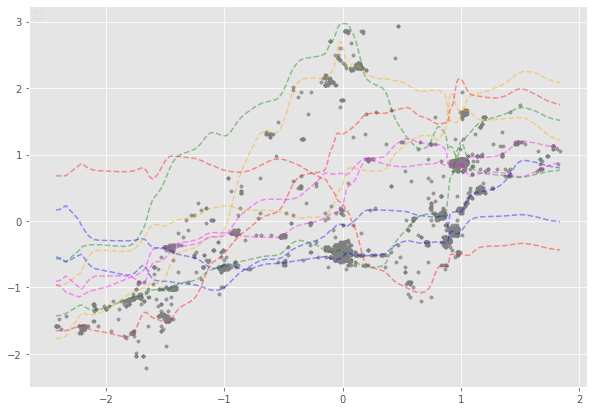

In [56]:
plt.figure(figsize=[10, 7])

#plt.scatter(full_res['X'], full_res['T'], alpha=0.2, color='grey', s=10)

plot_signif(1, full_res, plt_var=False, mc=False)
plot_signif(2, full_res, col1='red', col2='pink', plt_var=False, mc=False)
plot_signif(3, full_res, col1='green', col2='lightgreen', plt_var=False, mc=False)
plot_signif(4, full_res, col1='orange', col2='gold', plt_var=False, mc=False)
plot_signif(5, full_res, col1='magenta', col2='pink', plt_var=False, mc=False)
plot_signif(6, full_res, plt_var=False, mc=False)
plot_signif(7, full_res, col1='red', col2='pink', plt_var=False, mc=False)
plot_signif(8, full_res, col1='green', col2='lightgreen', plt_var=False, mc=False)
plot_signif(9, full_res, col1='orange', col2='gold', plt_var=False, mc=False)
plot_signif(10, full_res, col1='magenta', col2='pink', plt_var=False, mc=False)


plt.legend(loc='upper left', prop={'size': 10})
#plt.ylim([0, 1])

#fig = plt.gcf()
#fig.savefig("MDN_wavedata_f2.png")
#plt.draw()

#plt.show()

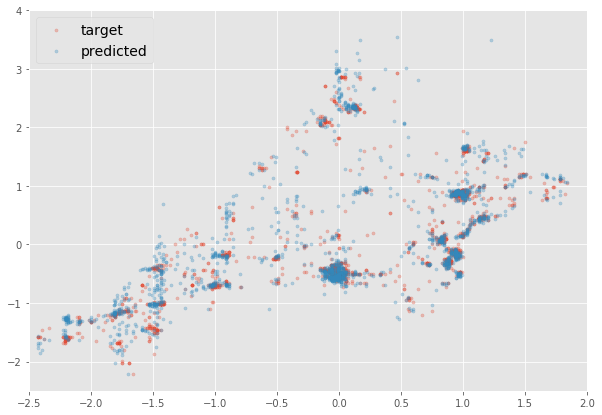

In [59]:
plt.figure(figsize=[10, 7])
plt.scatter(X_test[:,0], X_test[:,1], alpha = 0.3, label='target', s=10)
plt.scatter(X_test[:,0], t_pred.detach(), alpha = 0.3, label = 'predicted', s=10)
plt.legend(loc='upper left')

plt.xlim([-2.5, 2])
plt.ylim([-2.5, 4])
plt.legend(loc='upper left', prop={'size':14})

#fig = plt.gcf()
#fig.savefig("MDN_pred_investigation.png")
#plt.draw()
#plt.show()

#plt.figure(figsize=(10, 7))

# Root Mean Square (RMS)

In [73]:
counted_points = np.unique(np.array(X_data[:,1]), return_counts=True)
len(counted_points[1])

138

In [ ]:
diff = (t_pred - X_test[:,1].view(-1, 1))
L2_diff = np.square(diff)

avg_diff = sum(np.array(L2_diff)) / num_samples
RMS = np.sqrt(avg_diff)
print("RMS: {}".format(np.around(RMS, decimals=6)))

In [ ]:
plt.scatter(X_test[:, 0].view(-1, 1), L2_diff, s=10, alpha=0.2)
plt.xlim((-2.5, 2))
plt.ylim((0,15 ))

In [ ]:
plt.scatter(X_test[:, 0].view(-1, 1), diff, s=10, alpha=0.2)
plt.title("displacement plot")
plt.xlim((-2.5,2))

# Log Likelihood

In [ ]:
# log likelihood function for toy dataset
def toy_data_log_prob(t, x, var=0.09):
    lp_list =[]
    for i in tqdm(range(len(t))):
        sigma_sqr = float(0.09 * (x[i] ** 2))
        f = torch.distributions.normal.Normal(0, sigma_sqr)
        lp_list.append(f.log_prob(t[i]))
    return np.array(lp_list)

In [ ]:
# calculation of loglikelihood
LL = sum(toy_data_log_prob(diff, X_test[:,0].view(-1, 1)))
print("Log-likelihood of predicted targets: {}".format(LL))

# Model Summary

In [ ]:
# summary of model parameters
for name, param in model.named_parameters():
    print("{}\n{}\n".format(name, param))